In [23]:
import tensorflow as tf
import matplotlib.pyplot as plt
import QGOpt as qgo

#### Here one generates a random Hamiltonian.

In [24]:
#=========================================#
ham_dim = 100 # dimension of a Hamiltonian
#=========================================#

# random Hamiltonian
Q = qgo.manifolds.real_to_complex(tf.random.normal((ham_dim, ham_dim, 2), dtype=tf.float64))
Q, _ = tf.linalg.qr(Q)  # random unitary (QR based)

S = tf.random.uniform((ham_dim,), -3, 3)
S = tf.cast(S, dtype=tf.complex128)  # random spectrum

H = tf.einsum('ik,k,jk->ij', Q, S, tf.math.conj(Q))

# minimal eigenvalue of a Hamiltonian
min_value = tf.cast(tf.linalg.eigvalsh(H)[0],
                   dtype=tf.float64)

# initial density matrix
A = tf.random.normal((ham_dim, ham_dim, 2), dtype=tf.float64)
A = qgo.manifolds.real_to_complex(A)
A = A / tf.linalg.norm(A)
A = qgo.manifolds.complex_to_real(A)

#========= Positive cone manifold =============#
m = qgo.manifolds.DensityMatrix()
#==============================================#

#================================= optimizers================================#
opts = {
        'GD':qgo.optimizers.RSGD(m, 0.1),
        'GD_momentum':qgo.optimizers.RSGD(m, 0.2, 0.9),
        'Adam':qgo.optimizers.RAdam(m, 0.2),
        'Adam_with_ams':qgo.optimizers.RAdam(m, 0.2, ams=True)
       }
#=============================================================================#

#### Optimization loop solves the folloving optimization problem $${\rm Tr}(H\rho)\rightarrow \min_{\rho\in \{\rho\in\mathbb{S}_{++}:{\rm Tr}\rho =1\}},$$ by using different types of Riemannian optimizers

In [25]:
#=============================================#
number_of_steps = 3000  # number of iterations
#=============================================#

err_dict = {} # the disct will be filed by lists of errors vs optimizer

# loop over optimizers
for key, opt in opts.items():

    err = []  # will be filled by error vs iter
    A_var = tf.Variable(A)  # turning initial density matrix to variable
    
    # optimization loop
    for _ in range(number_of_steps):
        with tf.GradientTape() as tape:
            A_varc = qgo.manifolds.real_to_complex(A_var)
            loss = tf.linalg.trace((A_varc @ tf.linalg.adjoint(A_varc)) @ H)
            loss = tf.cast(loss, tf.float64)  # energy
            err.append(loss - min_value)
        grad = tape.gradient(loss, A_var)  # gradient
        opt.apply_gradients(zip([grad], [A_var]))  # optimization step
        
    err_dict[key] = err

#### Plotting the value of error vs iteration for each optimizer.

Text(0, 0.5, 'err')

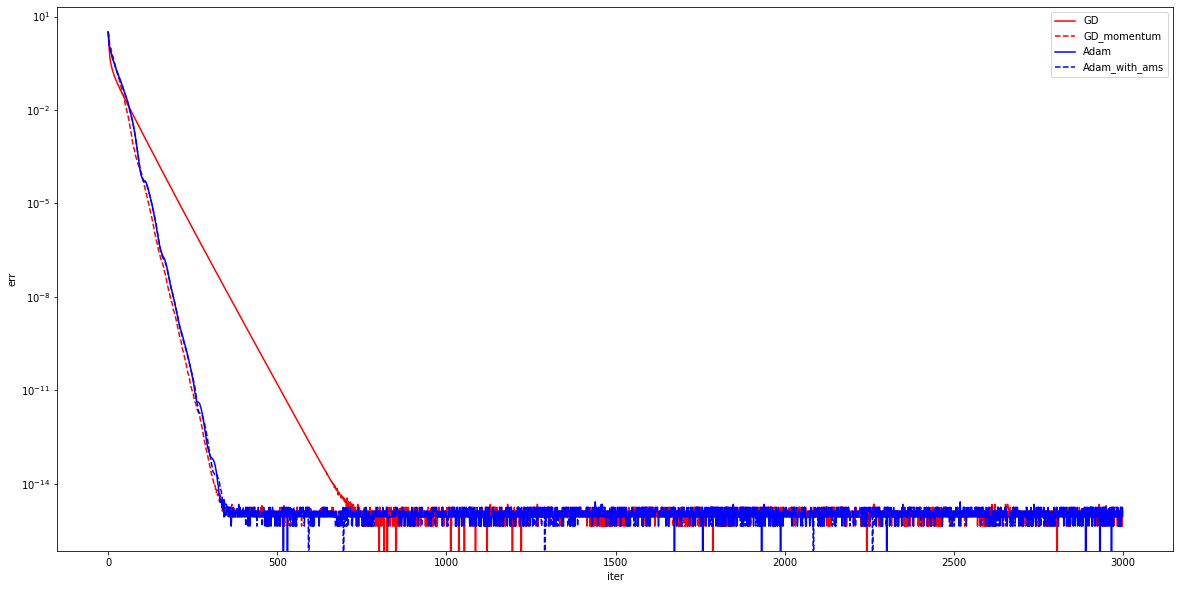

In [31]:
colors = ['r', 'r--', 'b', 'b--']
plt.figure(figsize=(20, 10))
for i, key in enumerate(opts.keys()):
    plt.plot(err_dict[key], colors[i])
plt.legend(opts.keys())
plt.yscale('log')
plt.xlabel('iter')
plt.ylabel('err')